# Un distort

this notebook contains code that try to warp the roi mask to rectangle

In [2]:
import os
import numpy as np
import cv2
import re
import matplotlib.pyplot as plt

In [3]:
def get_data():
    image_paths = [os.path.join('data/table-with-mask-1k/', f) for f in os.listdir('data/table-with-mask-1k/')]
    image_paths.sort()
    dataset = dict()
    for path in image_paths:
        img_id = re.sub('.*/(.*)(\.mask\.png|\.jpeg)', r'\1', path)
        img_data = dataset.get(img_id, dict())
        if path.endswith('.mask.png'):
            img_data['roi'] = path
        else:
            img_data['img'] = path
        dataset[img_id] = img_data
    return list(dataset.values())

In [4]:
dataset = get_data()

In [16]:
table_cropped_dir='data/table-cropped'
os.makedirs(table_cropped_dir, exist_ok=True)

In [67]:
def get_corners(points):
    """
    Returns the top-left, top-right, bottom-right, and bottom-left corners
    of a rectangle defined by a list of four points in the form of tuples.
    """
    # Sort points by x-coordinate
    sorted_points = sorted(points, key=lambda p: p[0])
    
    # Split sorted points into left and right halves
    left_points = sorted_points[:2]
    right_points = sorted_points[2:]
    
    # Sort left and right points by y-coordinate
    left_points = sorted(left_points, key=lambda p: p[1])
    right_points = sorted(right_points, key=lambda p: p[1], reverse=True)
    
    # Return corners in order: top-left, top-right, bottom-right, bottom-left
    return (left_points[0], right_points[0], right_points[1], left_points[1])

In [89]:
def warp_perspective(image, pt_A, pt_B, pt_C, pt_D):
    # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))
    
    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, maxHeight - 1],
                            [maxWidth - 1, maxHeight - 1],
                            [maxWidth - 1, 0]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    return cv2.warpPerspective(image,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

def _(image_data):
    img = cv2.imread(image_data['img'])
    roi_img = cv2.imread(image_data['roi'])
    roi_img = cv2.cvtColor(roi_img, cv2.COLOR_RGB2GRAY)
    contours, hierarchy = cv2.findContours(roi_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_rect = img.copy()
    img_hull = img.copy()
    img_point = img.copy()
    table_images = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        img_rect= cv2.drawContours(img_rect,[box],0,(0,0,255),2)
        hull = cv2. convexHull(cnt, returnPoints=False)
        defects = cv2.convexityDefects(cnt, hull)
        
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            cv2.line(img_hull, start, end, [0,255,0], 10)
            # cv2.circle(img_hull, far, 5, [0,0,255], -1)
        epsilon = cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt, 0.02*epsilon, True)
        points = np.squeeze(approx)
        tl, br, bl, tr = get_corners(points.tolist())
        if len(points) == 4:
            table_images.append(warp_perspective(img, tl, tr, br, bl))
        for p in [tl, tr, br, bl]:
            img_point = cv2.circle(img_point, p, 10, [0,0,255], -1)
    h,w,d = img.shape
#     fig, axes = plt.subplots(3, 2, figsize=(int(h/150), int(w/150)))
#     axes[0][0].imshow(roi_img,   cmap='gray')
#     axes[0][1].imshow(img_rect,  cmap='brg')
#     axes[1][0].imshow(img_hull,  cmap='brg')
#     axes[1][1].imshow(img_point, cmap='brg')

    img_name = os.path.basename(image_data['img']).split('.')[0]
    for i in range(len(table_images)):
#         axes[2][i].imshow(table_images[i])
        cv2.imwrite(os.path.join(table_cropped_dir, f'{img_name}_{i}.jpeg'), table_images[i])

d_i = np.random.randint(0, len(dataset))
_(dataset[d_i]),d_i

(None, 978)

In [90]:
for i in dataset:
    try:
        _(i)
    except:
        print(i)

{'img': 'data/table-with-mask-1k/0-1-091417c4253e22a2209bea9a55117dc90443cf3f.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-782978bab7cad703b568298d9295fc343abde629.jpg'}
{'img': 'data/table-with-mask-1k/0-1-a6873deb309cddc2c9e51a73beeabd7d2b169eb4.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-aa78f473ce4532597d82ef5eb183ecf5a3ee7645.jpg'}
{'img': 'data/table-with-mask-1k/0-1-b05807504dfe87ca46cc44e7a7fa807dbf8fb22b.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-b326581535c23802a2fa862275ac19a387d6701d.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-b371b6aae1da532f8bf65386596350a8d183c857.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-b76651fee87ec8641da1907d38dac3abec62b9f6.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-b8469d2b9d4c3ee1cd7e9ea9e13a0e10cd0df139.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-cc83e499f51ee7f67cc3fc36c35909aacd4b7829.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-cfd20e9e6fb98a236a80924ec18d655702016004.jpeg'}
{'img': 'data/table-with-mask-1k/0-1-d9f7bbc9c4b2c24326efa40098715c

[array([[[147, 143, 124],
         [147, 143, 124],
         [147, 143, 124],
         ...,
         [138, 138, 132],
         [137, 137, 131],
         [133, 135, 129]],
 
        [[147, 143, 124],
         [147, 143, 124],
         [147, 143, 124],
         ...,
         [133, 135, 129],
         [132, 134, 128],
         [131, 133, 127]],
 
        [[147, 143, 124],
         [145, 141, 122],
         [145, 141, 122],
         ...,
         [132, 134, 128],
         [131, 133, 127],
         [131, 133, 127]],
 
        ...,
 
        [[140, 138, 128],
         [140, 138, 128],
         [136, 134, 124],
         ...,
         [120, 123, 121],
         [121, 124, 122],
         [122, 125, 123]],
 
        [[141, 139, 129],
         [143, 137, 130],
         [143, 137, 130],
         ...,
         [121, 124, 122],
         [119, 122, 120],
         [123, 126, 124]],
 
        [[141, 139, 129],
         [142, 136, 129],
         [144, 138, 131],
         ...,
         [122, 125, 123],
  

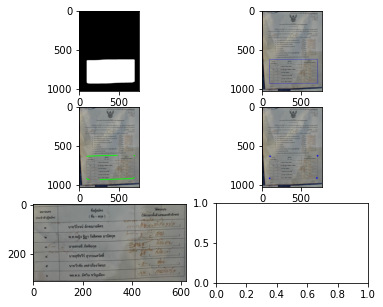

In [15]:
_(np.random.choice(dataset))